In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import torch.nn as nn
import torchvision.datasets as dset
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline

In [3]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root="./mnist_data", transform=trans, train=True)
test_set = dset.MNIST(root="./mnist_data", transform=trans, train=False)

In [4]:
vgg_mnist = models.vgg16()

In [5]:
num_ftrs = vgg_mnist.classifier[6].in_features

features = list(vgg_mnist.classifier.children())[:-1]

features.extend([nn.Linear(num_ftrs, 10)])

vgg_mnist.classifier = nn.Sequential(*features)

In [7]:
# 28 x 28

# 26 x 26

# 24 x 24
# 12 x 12

# 10 x 10

# 8 x 8
# 4 x 4

# 2 x 2

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [7]:
from torch.nn import MSELoss, NLLLoss2d, CrossEntropyLoss

In [8]:
from tqdm import tqdm_notebook
import numpy as np

In [9]:
oracle = nn.Sequential()

oracle.add_module("cl1", nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3))
oracle.add_module("bn_cl1", nn.BatchNorm2d(64))
oracle.add_module("relu_cl1", nn.ReLU(inplace = True))

oracle.add_module("cl2", nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3))
oracle.add_module("bn_cl2", nn.BatchNorm2d(64))
oracle.add_module("relu_cl2", nn.ReLU(inplace = True))
oracle.add_module("mp_cl2", nn.MaxPool2d(2))

oracle.add_module("cl3", nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3))
oracle.add_module("bn_cl3", nn.BatchNorm2d(128))
oracle.add_module("relu_cl3", nn.ReLU(inplace = True))

oracle.add_module("cl4", nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3))
oracle.add_module("bn_cl4", nn.BatchNorm2d(128))
oracle.add_module("relu_cl4", nn.ReLU(inplace = True))
oracle.add_module("mp_cl4", nn.MaxPool2d(2))

# oracle.add_module("cl5", nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3))
# oracle.add_module("bn_cl5", nn.BatchNorm2d(256))
# oracle.add_module("relu_cl5", nn.ReLU(inplace = True))

oracle.add_module("flatten", Flatten())

oracle.add_module("lr1", nn.Linear(in_features = 4 * 4 * 128, out_features = 256))
oracle.add_module("bn_lr1", nn.BatchNorm1d(256))
oracle.add_module("relu_lr1", nn.ReLU(inplace = True))

# oracle.add_module("lr2", nn.Linear(in_features = 256, out_features = 128))
# oracle.add_module("bn_lr2", nn.BatchNorm1d(128))
# oracle.add_module("relu_lr2", nn.ReLU(inplace = True))

oracle.add_module("lr3", nn.Linear(in_features = 256, out_features = 32))
oracle.add_module("bn_lr3", nn.BatchNorm1d(32))
oracle.add_module("relu_lr3", nn.ReLU(inplace = True))

oracle.add_module("lr4", nn.Linear(in_features = 32, out_features = 10))
oracle.add_module("relu_lr4", nn.ReLU(inplace = True))

oracle.add_module("sofmax", nn.Softmax())

In [10]:
opt = torch.optim.Adam(oracle.parameters(), lr=0.000005)
loss_mse = MSELoss()
train_loss = []
test_acc = []
num_epochs = 40
num_classes = 10
batch_size = 100

In [11]:
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [12]:
oracle.cuda()

for epoch in range(num_epochs):
    oracle.train(True)
    for (i_batch, sample_batched) in tqdm_notebook(enumerate(train_loader)):
        X_batch = Variable(sample_batched[0].cuda())
#         X_batch = Variable(sample_batched[0])
        y_pred = oracle(X_batch)
        y_true = sample_batched[1]

        ans = []
        for i in range(batch_size):
            zer = np.zeros(num_classes)
            zer[y_true[i]] = 1
            ans.append(zer)
        ans = torch.FloatTensor(ans)

        loss = loss_mse(y_pred, Variable(ans.cuda()))
#         loss = loss_mse(y_pred, Variable(ans))
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
#         train_loss.append(loss.data.numpy())
    print("epoch #%i, loss = %.4f" % (epoch + 1, train_loss[-1]))

    oracle.train(False)
    for (i_test_batch, sample_test_batched) in tqdm_notebook(enumerate(test_loader)):
        X_test_batch = sample_test_batched[0]
        logits = oracle(Variable(X_test_batch.cuda()))
#         logits = oracle(Variable(X_test_batch))
        y_test_pred = torch.max(logits, 1)[1].cpu().data.numpy()
#         y_test_pred = torch.max(logits, 1)[1].data.numpy()
        y_test_true = sample_test_batched[1].cpu().numpy()
#         y_test_true = sample_test_batched[1].data.numpy()
        test_acc.append(np.mean(y_test_pred == y_test_true))
    print("accuracy = %.4f" % (test_acc[-1]))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

/usr/local/lib/python2.7/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



epoch #1, loss = 0.0755


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.6200


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #2, loss = 0.0714


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.6800


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #3, loss = 0.0706


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.7500


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #4, loss = 0.0682


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.7800


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #5, loss = 0.0669


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.8400


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #6, loss = 0.0645


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.8400


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #7, loss = 0.0638


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.8600


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #8, loss = 0.0633


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.8700


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #9, loss = 0.0619


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9200


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #10, loss = 0.0613


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9400


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #11, loss = 0.0595


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9600


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #12, loss = 0.0592


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9700


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #13, loss = 0.0572


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9700


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #14, loss = 0.0557


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9700


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #15, loss = 0.0565


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9700


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #16, loss = 0.0552


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9700


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #17, loss = 0.0533


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9700


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #18, loss = 0.0512


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9800


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #19, loss = 0.0506


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9800


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #20, loss = 0.0493


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9800


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #21, loss = 0.0494


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9800


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #22, loss = 0.0463


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9800


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #23, loss = 0.0473


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9800


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #24, loss = 0.0451


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9900


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #25, loss = 0.0430


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9800


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #26, loss = 0.0421


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9900


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #27, loss = 0.0400


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9900


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #28, loss = 0.0393


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9900


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #29, loss = 0.0394


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9900


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #30, loss = 0.0369


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9900


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #31, loss = 0.0355


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 0.9900


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #32, loss = 0.0373


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 1.0000


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #33, loss = 0.0330


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 1.0000


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #34, loss = 0.0328


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 1.0000


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #35, loss = 0.0311


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 1.0000


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #36, loss = 0.0295


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 1.0000


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #37, loss = 0.0285


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 1.0000


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #38, loss = 0.0306


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 1.0000


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #39, loss = 0.0270


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 1.0000


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


epoch #40, loss = 0.0269


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


accuracy = 1.0000


In [13]:
train_loss_av = []

In [14]:
for i in range(len(train_loss) / len(train_loader)):
    train_loss_av.append(np.mean(train_loss[i * len(train_loader) : (i + 1) * len(train_loader)]))

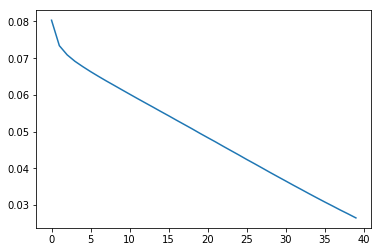

In [17]:
plt.plot(train_loss_av)

In [18]:
test_acc_av = []

In [19]:
for i in range(len(test_acc) / len(test_loader)):
    test_acc_av.append(np.mean(test_acc[i * len(test_loader) : (i + 1) * len(test_loader)]))

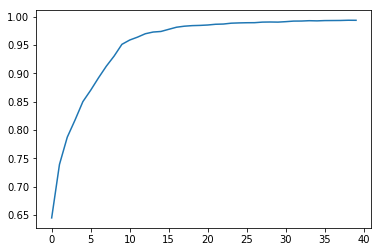

In [20]:
plt.plot(test_acc_av)

We've obtained oracle. Let's now create some more simple net to perform missclassification.

In [21]:
miscl_net = nn.Sequential()

miscl_net.add_module("cl1", nn.Conv2d(in_channels = 1, out_channels = 30, kernel_size = 3))
miscl_net.add_module("bn_cl1", nn.BatchNorm2d(30))
miscl_net.add_module("relu_cl1", nn.ReLU(inplace = True))

# oracle.add_module("cl2", nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3))
# oracle.add_module("bn_cl2", nn.BatchNorm2d(64))
# oracle.add_module("relu_cl2", nn.ReLU(inplace = True))
# oracle.add_module("mp_cl2", nn.MaxPool2d(2))

miscl_net.add_module("cl3", nn.Conv2d(in_channels = 30, out_channels = 100, kernel_size = 3))
miscl_net.add_module("bn_cl3", nn.BatchNorm2d(100))
miscl_net.add_module("relu_cl3", nn.ReLU(inplace = True))
miscl_net.add_module("mp_cl3", nn.MaxPool2d(2))

# oracle.add_module("cl4", nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3))
# oracle.add_module("bn_cl4", nn.BatchNorm2d(128))
# oracle.add_module("relu_cl4", nn.ReLU(inplace = True))
# oracle.add_module("mp_cl4", nn.MaxPool2d(2))

# oracle.add_module("cl5", nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3))
# oracle.add_module("bn_cl5", nn.BatchNorm2d(256))
# oracle.add_module("relu_cl5", nn.ReLU(inplace = True))

miscl_net.add_module("flatten", Flatten())

miscl_net.add_module("lr1", nn.Linear(in_features = 12 * 12 * 100, out_features = 512))
miscl_net.add_module("bn_lr1", nn.BatchNorm1d(512))
miscl_net.add_module("relu_lr1", nn.ReLU(inplace = True))

# oracle.add_module("lr2", nn.Linear(in_features = 256, out_features = 128))
# oracle.add_module("bn_lr2", nn.BatchNorm1d(128))
# oracle.add_module("relu_lr2", nn.ReLU(inplace = True))

# oracle.add_module("lr3", nn.Linear(in_features = 256, out_features = 32))
# oracle.add_module("bn_lr3", nn.BatchNorm1d(32))
# oracle.add_module("relu_lr3", nn.ReLU(inplace = True))

miscl_net.add_module("lr4", nn.Linear(in_features = 512, out_features = 10))
miscl_net.add_module("relu_lr4", nn.ReLU(inplace = True))

miscl_net.add_module("sofmax", nn.Softmax())

In [22]:
def jacobian(inputs, outputs):
    return torch.stack([grad([outputs[:, i].sum()], [inputs], retain_graph=True, create_graph=True)[0]
                        for i in range(outputs.size(1))], dim=-1)

In [23]:
small_set = []
small_set_answ = []

In [24]:
for i, j in train_loader:
    for idx in range(20):
        small_set.append(i[idx])
        small_set_answ.append(j[idx])
    break

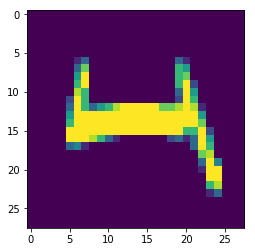

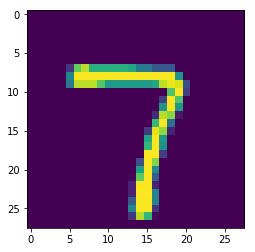

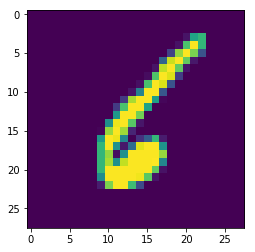

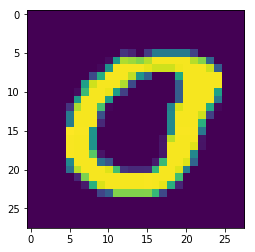

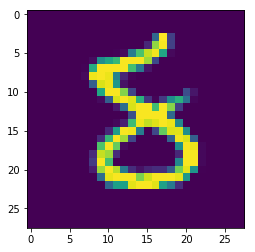

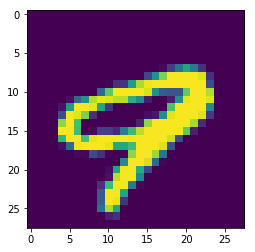

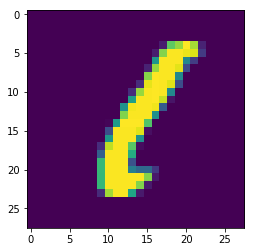

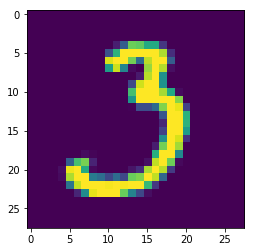

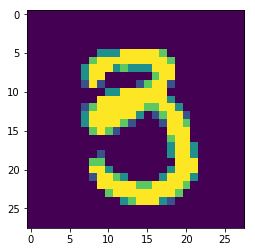

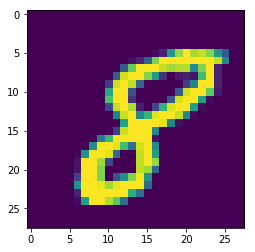

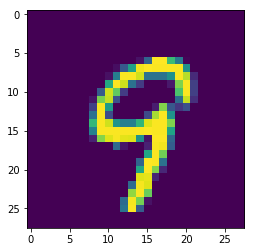

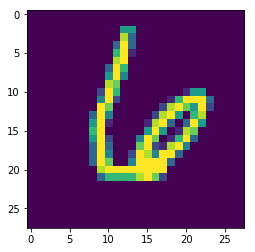

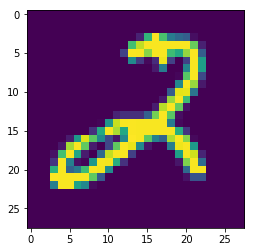

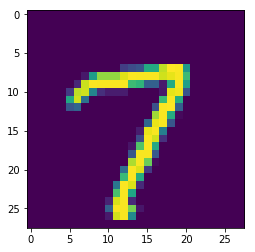

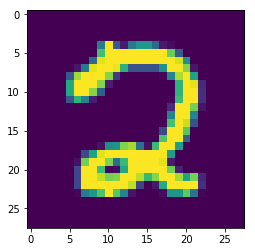

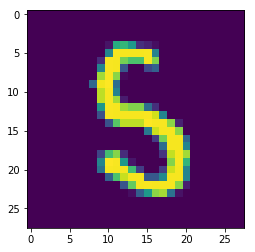

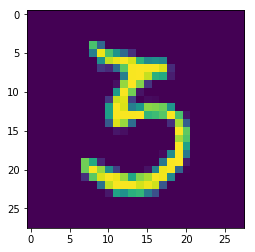

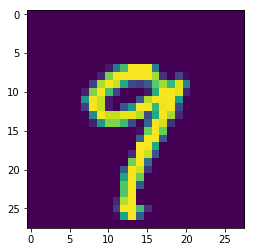

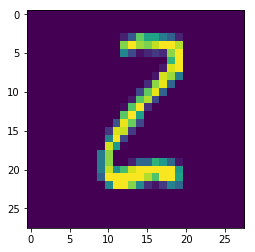

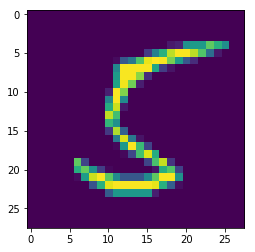

In [25]:
for i in range(len(small_set)):
    plt.imshow(small_set[i].numpy()[0, :, :])
    plt.show()

In [26]:
opt = torch.optim.Adam(oracle.parameters(), lr=0.000005)
loss_mse = MSELoss()
train_loss = []
test_acc = []
num_epochs = 1
num_classes = 10
batch_size = 1

In [27]:
Lambda = 0.3

In [28]:
torch.from_numpy(np.sign(np.ones((3, 3)) * 14))

tensor([[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]], dtype=torch.float64)

In [29]:
for (num, small_set_el) in tqdm_notebook(enumerate(small_set)):
    print(jacobian(small_set_el, miscl_net(Variable(small_set_el.cuda()))))

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

RuntimeError: expected stride to be a single integer value or a list of 1 values to match the convolution dimensions, but got stride=[1, 1]

In [185]:
miscl_net.cuda()

for epoch in range(num_epochs):
    miscl_net.train(True)
    for (num, small_set_el) in tqdm_notebook(enumerate(small_set)):
        X_batch = Variable(small_set_el.cuda())
        y_pred = miscl_net(X_batch)
        y_true = small_set_answ[num]

        ans = []
        for i in range(batch_size):
            zer = np.zeros(num_classes)
            zer[y_true[i]] = 1
            ans.append(zer)
        ans = torch.FloatTensor(ans)

        loss = loss_mse(y_pred, Variable(ans.cuda()))
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    logits = miscl_net(Variable(X_test_batch.cuda()))

    y_test_pred = torch.max(logits, 1)[1].cpu().data.numpy()

    temp_arr = []
    for (num, small_set_el) in tqdm_notebook(enumerate(small_set)):
        temp_arr.append(small_set_el + Lambda * torch.from_numpy()

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

RuntimeError: input and target shapes do not match: input [100 x 10], target [1 x 10] at /pytorch/aten/src/THCUNN/generic/MSECriterion.cu:15